# light gbm-cv 데모
* cross-validation
검증 방법: hold out validation, n-fold cv, stratified n-fold cv,leave one out
## 라이브러리 import 및 설정

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [3]:
data_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')
sub_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\sub\\')
feature_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')

val_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\val')
tst_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\tst')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 3054

In [4]:
algo_name = 'lgbcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
#df.head()

(400000, 20)


In [7]:
y = df[target_col].values[:320000]         #종속
df.drop(target_col, axis=1, inplace=True)  #독립을 위한 종속 제거
trn = df.iloc[:320000]                     #train을 위한 독립 320000개     
tst = df.iloc[320000:]                     #test을 위한 독립 80000개
feature_name = df.columns.tolist()         #독립변수 이름 리스트로 변환
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


## Stratified K-Fold Cross Validation
*Stratified N-Fold CV: N-Fold CV에서 각각의 폴드에서 종속변수의 분포가 동일하도록 폴드를 나누는 방식.  
현재 사용하는 데이터처럼 분류학습에서 종속변수의 범주의 분포가 균일하지 않을 때 사용된다.

In [8]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습


In [ ]:
#3000 256 0.009 1000 1 1 0.8 seed -1
#93.3453%
#3000 256 0.009 2000 1 1 0.8 seed -1
#93.4022%
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
#(cv.split(),1)
# -  StratifiedKFold 경우, trn,y 독립과 종속(동일 분포를 위해) 인자
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             #종속 타입에 따라 변경 가능 
                             n_estimators=3000,
                             num_leaves=256,
                             learning_rate=0.009,
                             subsample=.8,
                             subsample_freq=1,
                             num_iteration=2000,
                             colsample_bytree=.6,
                             random_state=seed,
                             n_jobs=-1)
    
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=15)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    #확률로 예측값 출력
    p_tst += clf.predict_proba(tst) / n_fold
    #평균 효과를 위해 먼저 폴드 개수만큼 나누어 초기화

**( 범주값 출력: clf.pedict(), 확률값출력: clf.predict_proba() )**

In [10]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%') 
# np.argmax 사용하여 확률 예측값을 클래스로 변경

93.4022%


In [8]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


[stacking 사용을 위해 p_val,p_tst 저장]

In [9]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

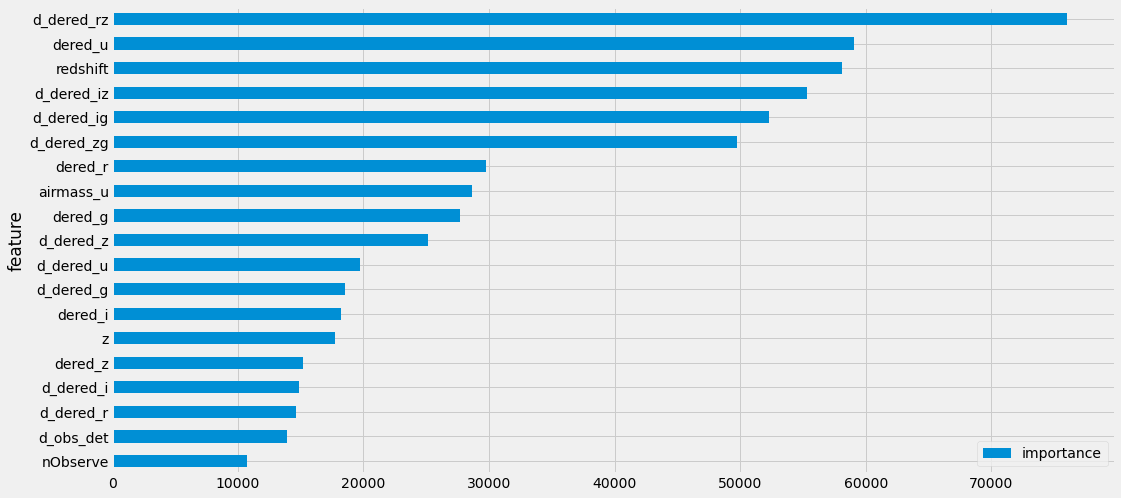

In [10]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성


In [8]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [9]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [10]:
sub[target_col].value_counts()

2    41059
0    29973
1     8968
Name: class, dtype: int64

In [11]:
sub.to_csv(sub_file)